In [1]:
import scanpy as sc

In [3]:
# load datasets
sc_ref = "/goofys/Samples/sc_reference/mouse_brain_L5_csr.h5ad"
stereoseq_file_path = "/goofys/Samples/Stereo_seq/Mouse_brain/SS200000141TL_B5.h5ad"
adata_sc = sc.read(sc_ref)
adata_st = sc.read(stereoseq_file_path)

/home/nikola_dev/miniconda3/envs/ssi/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/nikola_dev/miniconda3/envs/ssi/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/home/nikola_dev/miniconda3/envs/ssi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/nikola_dev/miniconda3/envs/ssi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


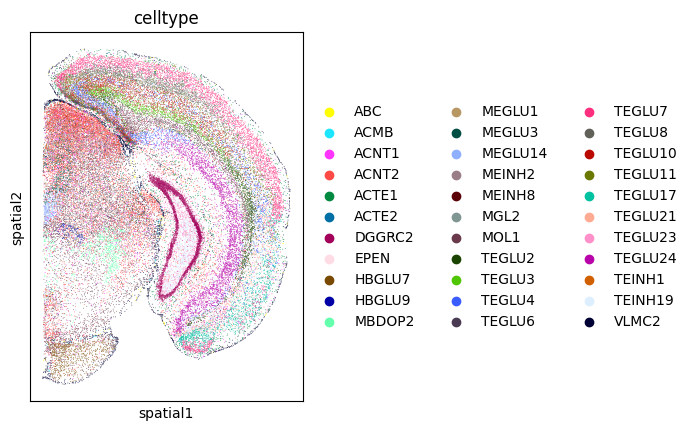

In [4]:
adata_st.obsm['spatial'] = adata_st.obsm['3D_spatial_stereoseq'].values
sc.pl.spatial(adata_st, spot_size=25, color='celltype')

In [5]:
from pympler import asizeof
def get_size_mb(obj):
    sz = asizeof.asizeof(obj)
    return  sz / (1024**2)

In [5]:
cells_selected = adata_st.obs['celltype'].unique()
adata_sc = adata_sc[adata_sc.obs['cell_subclass'].isin(cells_selected)]

/home/nikola_dev/miniconda3/envs/ssi/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [6]:
adata_sc.obs['cell_subclass'].value_counts()


cell_subclass
MOL1       8715
ACNT1      6642
ACTE2      3973
DGGRC2     3385
TEGLU8     3071
ACTE1      2974
TEGLU3     2734
ACNT2      2568
TEGLU7     2435
TEGLU24    2037
MGL2       1820
TEGLU11    1464
TEINH19    1040
TEGLU10     866
ACMB        861
TEGLU17     784
EPEN        774
TEGLU4      664
VLMC2       662
TEGLU6      598
TEINH1      576
TEGLU23     484
MEINH2      461
HBGLU7      275
TEGLU2      274
MEGLU1      263
MEGLU3      137
ABC         137
TEGLU21     104
HBGLU9       97
MEINH8       71
MBDOP2       63
MEGLU14      47
Name: count, dtype: int64

In [7]:
adata_sc.obs_names_make_unique()
adata_sc.var_names_make_unique()

/home/nikola_dev/miniconda3/envs/ssi/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/nikola_dev/miniconda3/envs/ssi/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikola_dev/miniconda3/envs/ssi/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/nikola_dev/miniconda3/envs/ssi/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
# just a note 
# pip install imbalanced-learn
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import make_pipeline

# # Create a pipeline with SMOTE and RandomUnderSampler
# pipeline = make_pipeline(SMOTE(), RandomUnderSampler())

# # Fit and transform your training data
# X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

AnnData object with n_obs × n_vars = 51056 × 27998
    obs: 'cell_subclass', 'cell_class'

In [8]:
counts_per_ct = adata_sc.obs['cell_subclass'].value_counts().values
cts = list(adata_sc.obs['cell_subclass'].value_counts().index)
max_count, min_count = max(counts_per_ct), min(counts_per_ct)
upper_bound, lower_bound = int(max_count * 0.75), int(max_count * 0.25)
upper_bound, lower_bound
print(counts_per_ct)
print("Bounds", upper_bound, lower_bound)

# scale original abundance to fit 0.25-0.75 of max 
def normalize(max_count, min_count, new_max, new_min, x):
    tmp = (x - min_count) / (max_count - min_count)
    return int(tmp * (new_max - new_min) + new_min)

[8715 6642 3973 3385 3071 2974 2734 2568 2435 2037 1820 1464 1040  866
  861  784  774  664  662  598  576  484  461  275  274  263  137  137
  104   97   71   63   47]
Bounds 6536 2178


In [9]:
# resampling per class
normalized_counts_per_ct = [normalize(max_count, min_count, upper_bound, lower_bound, el) for el in counts_per_ct]
total_new_cells = sum(normalized_counts_per_ct)
resampling_class_size = list(zip(normalized_counts_per_ct, counts_per_ct, cts))
resampling_class_size # (new, original, cell_type)

[(6536, 8715, 'MOL1'),
 (5493, 6642, 'ACNT1'),
 (4151, 3973, 'ACTE2'),
 (3856, 3385, 'DGGRC2'),
 (3698, 3071, 'TEGLU8'),
 (3649, 2974, 'ACTE1'),
 (3528, 2734, 'TEGLU3'),
 (3445, 2568, 'ACNT2'),
 (3378, 2435, 'TEGLU7'),
 (3178, 2037, 'TEGLU24'),
 (3069, 1820, 'MGL2'),
 (2890, 1464, 'TEGLU11'),
 (2677, 1040, 'TEINH19'),
 (2589, 866, 'TEGLU10'),
 (2587, 861, 'ACMB'),
 (2548, 784, 'TEGLU17'),
 (2543, 774, 'EPEN'),
 (2488, 664, 'TEGLU4'),
 (2487, 662, 'VLMC2'),
 (2455, 598, 'TEGLU6'),
 (2443, 576, 'TEINH1'),
 (2397, 484, 'TEGLU23'),
 (2386, 461, 'MEINH2'),
 (2292, 275, 'HBGLU7'),
 (2292, 274, 'TEGLU2'),
 (2286, 263, 'MEGLU1'),
 (2223, 137, 'MEGLU3'),
 (2223, 137, 'ABC'),
 (2206, 104, 'TEGLU21'),
 (2203, 97, 'HBGLU9'),
 (2190, 71, 'MEINH8'),
 (2186, 63, 'MBDOP2'),
 (2178, 47, 'MEGLU14')]

In [16]:
# total_new_cells
from scipy.sparse import csr_matrix
import anndata as ad
import numpy as np

genes = adata_sc.shape[1]

counts = np.zeros((total_new_cells, genes), dtype=np.int16)
new_adata = ad.AnnData(counts)
new_adata.var_names = adata_sc.var_names
new_adata.obs['cell_subclass'] = np.nan
new_adata

AnnData object with n_obs × n_vars = 96750 × 27998
    obs: 'cell_subclass'

In [17]:
# do the data augmentation, if there are less cells of some type than needed (else branch),
# take random.choices which will take elements with replacement
# otherwise use random.sample to take a subset of original data

import numpy as np
import random

ind = 0
genes = adata_sc.shape[1]
perc = 0.4


for new_size, original_size, label in resampling_class_size:
    if new_size <= original_size:
        # take unique cells and mutate
        adata_single_ct = adata_sc[adata_sc.obs['cell_subclass'] == label, :]
        for obs_name in random.sample(list(adata_single_ct.obs_names), k = new_size):
            new_adata.obs['cell_subclass'][ind] = label
            to_mutate = adata_sc[obs_name].X.toarray().astype(np.int16)[0]
            non_zero_indices = np.nonzero(to_mutate)
            num_elements_to_zero = int(perc * len(non_zero_indices))
            selected_indices = random.choices(non_zero_indices, k=num_elements_to_zero)
            to_mutate[selected_indices] = 0
            new_adata[ind].X = to_mutate
            ind += 1
    else:
        # you have to oversample by duplicating, draw random samples with replacement
        adata_single_ct = adata_sc[adata_sc.obs['cell_subclass'] == label, :]
        for obs_name in random.choices(adata_single_ct.obs_names, k = new_size):
            # mutate here
            new_adata.obs['cell_subclass'][ind] = label
            to_mutate = adata_sc[obs_name].X.toarray().astype(np.int16)
            non_zero_indices = np.nonzero(to_mutate)
            num_elements_to_zero = int(perc * len(non_zero_indices))
            selected_indices = random.choices(non_zero_indices, k=num_elements_to_zero)
            to_mutate[selected_indices] = 0
            new_adata[ind].X = to_mutate
            ind += 1

/home/nikola_dev/miniconda3/envs/ssi/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/tmp/ipykernel_143839/659331346.py:18: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  new_adata.obs['cell_subclass'][ind] = label
/tmp/ipykernel_143839/659331346.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'MOL1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_adata.obs['cell_subclass'][ind] = label
/tmp/ipykernel_143839/659331346.py:31: FutureWarning: Series.__setitem__ treating keys as positions i

In [18]:
new_adata.obs['cell_subclass'] = new_adata.obs['cell_subclass'].astype('category')

In [19]:
new_adata.obs['cell_subclass']

0           MOL1
1           MOL1
2           MOL1
3           MOL1
4           MOL1
          ...   
96745    MEGLU14
96746    MEGLU14
96747    MEGLU14
96748    MEGLU14
96749    MEGLU14
Name: cell_subclass, Length: 96750, dtype: category
Categories (33, object): ['ABC', 'ACMB', 'ACNT1', 'ACNT2', ..., 'TEGLU8', 'TEINH1', 'TEINH19', 'VLMC2']

In [20]:
# to confirm that the number of nonzero elements per row of GE matrix decreased
cnt_new = 0
cnt_old = 0
NUM = 20_000
for i in range(NUM):
    cnt_old += len(np.nonzero(adata_sc[i].X)[1])
    cnt_new += len(np.nonzero(new_adata[i].X)[1])

print("avg old", cnt_old/NUM)
print("avg new", cnt_new/NUM)


/home/nikola_dev/miniconda3/envs/ssi/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


avg old 1981.28325
avg new 1078.99345


In [21]:
# convert to sparse format for efficient manipulation and storage
new_adata.X = csr_matrix(new_adata.X)

In [25]:
new_adata.write('mouse_brain_L5_csr_rebalanced_augmented.h5ad')
# adata = sc.read('mouse_brain_L5_csr_rebalanced_augmented.h5ad')

In [26]:
adata = sc.read('/goofys/Samples/sc_reference/mouse_brain_L5_csr_rebalanced_augmented.h5ad')
adata


AnnData object with n_obs × n_vars = 96750 × 27998
    obs: 'cell_subclass'

In [27]:
adata.var_names

Index(['Cbln2', 'Ptchd2', 'P2rx2', 'Ptger4', 'Fam19a1', 'Slc12a7', 'Tlx2',
       'Hoxa3', 'Adgrg6', 'Dgkg',
       ...
       'Micu1', 'Usp20', 'Dolpp1', 'Selo', 'Sh3glb2', 'BC051537', 'Gm15518',
       'Mmadhc', 'Med27', 'Psmc6'],
      dtype='object', length=27998)